## Question 1  Analysis

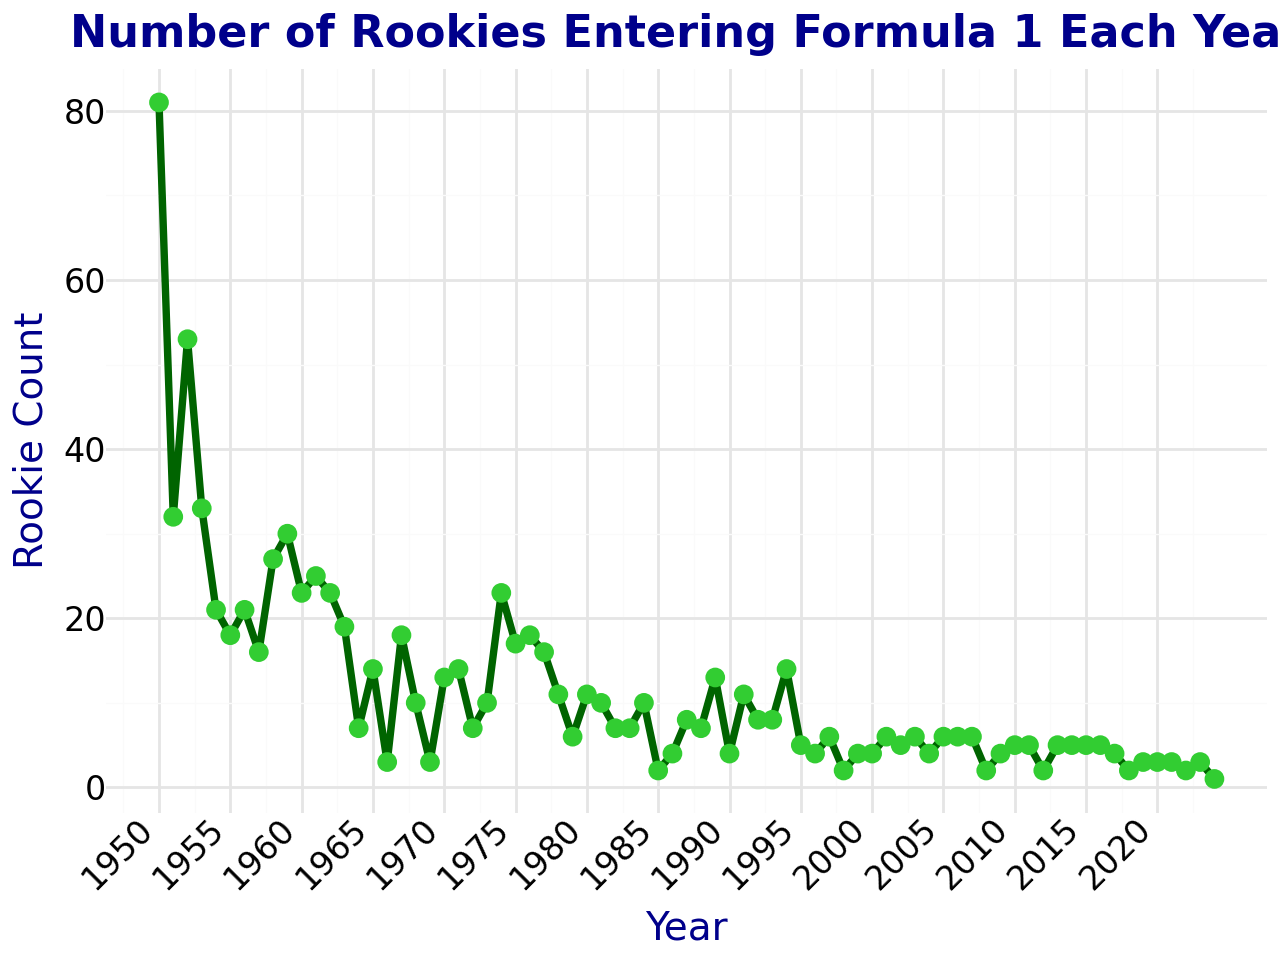

In [42]:
import numpy as np
import pandas as pd
from plotnine import *

# Load datasets
drivers_df = pd.read_csv('https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/newDrivers.csv')
races_df = pd.read_csv('https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/newRaces.csv')
results_df = pd.read_csv('https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/newResults.csv')

# Merge the results with races to get race date for each driver's result
results_with_race_date = pd.merge(results_df, races_df[['raceId', 'date']], on='raceId', how='left')

# Convert the date columns to datetime format
drivers_df['dob'] = pd.to_datetime(drivers_df['dob'])
results_with_race_date['date'] = pd.to_datetime(results_with_race_date['date'])

# Find the first race for each driver (minimum race date per driverId)
first_race_per_driver = results_with_race_date.groupby('driverId')['date'].min().reset_index()

# Merge with drivers data to get DOB and calculate age at the first race
driver_first_race = pd.merge(first_race_per_driver, drivers_df[['driverId', 'forename', 'surname', 'dob']], on='driverId')
driver_first_race['age_at_first_race'] = (driver_first_race['date'] - driver_first_race['dob']).dt.days // 365

# Extract the year of the first race for each driver
driver_first_race['first_race_year'] = driver_first_race['date'].dt.year

# Count the number of rookies entering Formula 1 each year
rookie_count_per_year = driver_first_race.groupby('first_race_year').size().reset_index()
rookie_count_per_year.columns = ['Year', 'Rookie Count']

# Improved plot for rookie count per year
plot = (
    ggplot(rookie_count_per_year, aes(x='Year', y='Rookie Count')) +
    geom_line(color='darkgreen', size=1.5) +  # Line for rookie count
    geom_point(color='limegreen', size=3) +  # Points to highlight data
    labs(
        title='Number of Rookies Entering Formula 1 Each Year',
        x='Year',
        y='Rookie Count'
    ) +
    scale_x_continuous(breaks=range(rookie_count_per_year['Year'].min(), rookie_count_per_year['Year'].max() + 1, 5)) +  # Spread out x-axis labels
    theme_minimal() +
    theme(
        plot_title=element_text(size=16, weight='bold', ha='center', color='darkblue'),
        axis_title_x=element_text(size=14, color='darkblue'),
        axis_title_y=element_text(size=14, color='darkblue'),
        axis_text_x=element_text(size=12, angle=45, ha='right', color='black'),
        axis_text_y=element_text(size=12, color='black')
    )
)

# Display the plot
plot


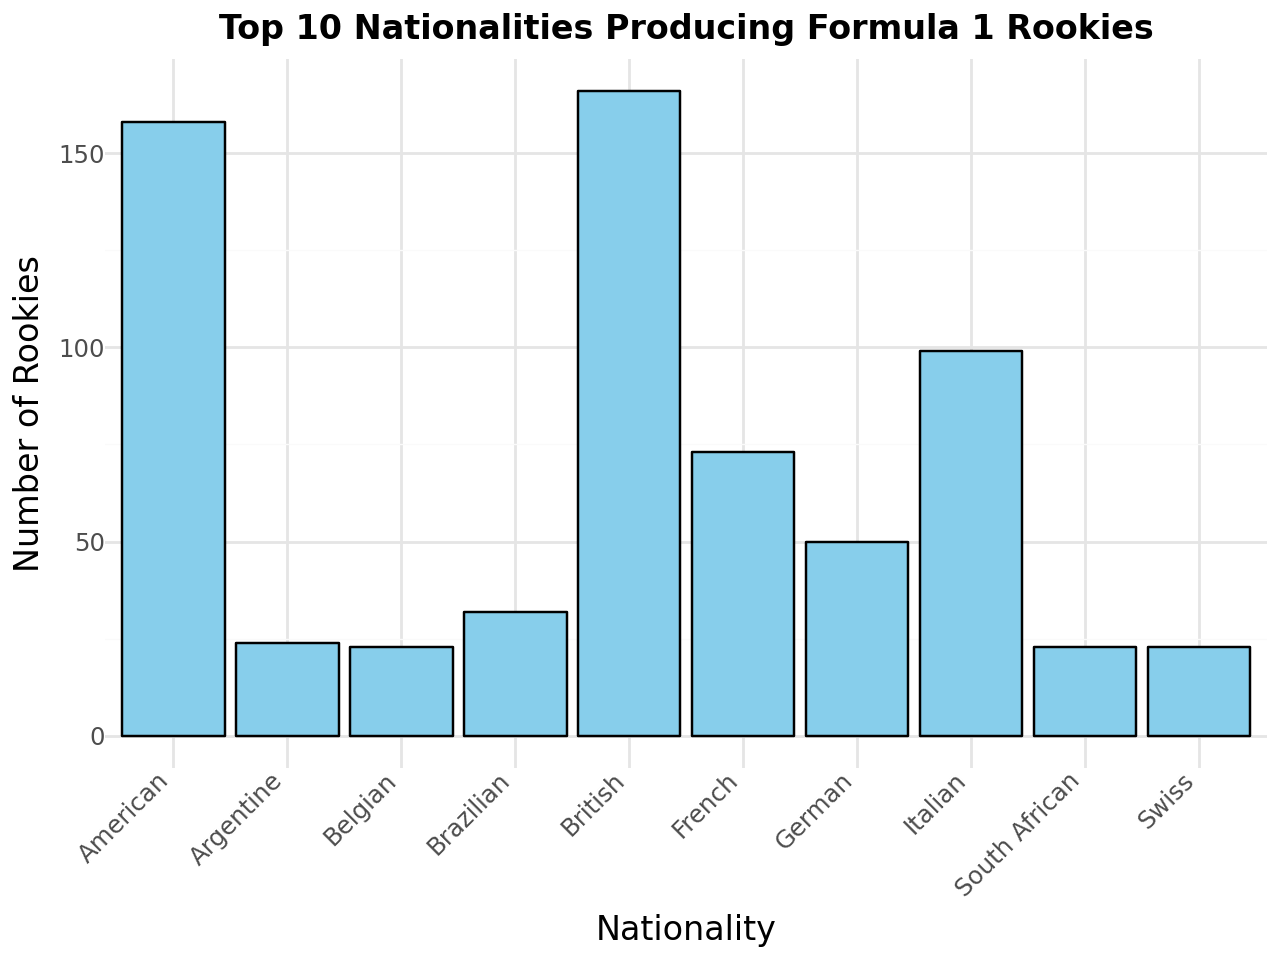

In [39]:
# Count rookies by nationality
rookie_nationality_count = drivers_df['nationality'].value_counts().reset_index()
rookie_nationality_count.columns = ['Nationality', 'Count']

# Filter top 10 countries
top_nationalities = rookie_nationality_count.head(10)

# Create the bar plot
from plotnine import geom_bar

plot = (
    ggplot(top_nationalities, aes(x='Nationality', y='Count')) +
    geom_bar(stat='identity', fill='skyblue', color='black') +
    labs(
        title='Top 10 Nationalities Producing Formula 1 Rookies',
        x='Nationality',
        y='Number of Rookies'
    ) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=12, weight='bold'),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text_x=element_text(rotation=45, ha='right')
    )
)

# Display the plot
plot

### Question 2 Analysis


In [ ]:
# Import required libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal

# File paths (adjust if needed)
fastest_laps_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/fastestlaps_detailed.csv'
pitstops_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/pitstops.csv'

# Read datasets
fastest_laps = pd.read_csv(fastest_laps_path)
pitstops = pd.read_csv(pitstops_path)

# Function to convert time strings into seconds
def time_to_seconds(time_str):
    if pd.isnull(time_str) or not isinstance(time_str, str):
        return None
    try:
        parts = time_str.split(':')
        if len(parts) == 2:  # MM:SS.sss
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:  # HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return None
    except ValueError:
        return None

# Apply time conversion
fastest_laps['Time'] = fastest_laps['Time'].apply(time_to_seconds)
if 'Total' in pitstops:
    pitstops['Total'] = pitstops['Total'].apply(time_to_seconds)

# Encode Driver and Car as numerical features
fastest_laps['DriverEncoded'] = pd.factorize(fastest_laps['Driver'])[0]
fastest_laps['CarEncoded'] = pd.factorize(fastest_laps['Car'])[0]

# Extract and combine features
lap_times = fastest_laps[['Time']].dropna()  # Lap times
pitstop_durations = pitstops[['Total']].dropna() if 'Total' in pitstops else None  # Pitstop durations
positions = fastest_laps[['DriverEncoded', 'CarEncoded']].dropna()  # Encoded features

# Combine lap times, pitstop durations, and encoded features
if pitstop_durations is not None:
    combined_features = pd.concat([lap_times, pitstop_durations], axis=1).dropna()
else:
    combined_features = lap_times

# Add encoded features
combined_features = pd.concat([combined_features, positions], axis=1).dropna()

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(combined_features)

# Apply PCA
pca = PCA()
data_pca = pca.fit_transform(data_standardized)
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Retain top components that explain ~95% variance
n_components = sum(explained_variance_ratio < 0.95) + 1
pca = PCA(n_components=n_components)
data_pca_reduced = pca.fit_transform(data_standardized)

# Prepare target variable (lap times for simplicity)
y = lap_times['Time'][:len(combined_features)]  # Ensure matching indices
X = combined_features  # Features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca_reduced, y, test_size=0.2, random_state=42)

# Train model on original data
model_original = LinearRegression()
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)

# Metrics for original data
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

# Train model on PCA-transformed data
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = model_pca.predict(X_test_pca)

# Metrics for PCA-transformed data
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

# Output results
results = {
    "Original Data": {
        "MSE": mse_original,
        "R²": r2_original
    },
    "PCA-Transformed Data": {
        "MSE": mse_pca,
        "R²": r2_pca
    }
}

print("Performance Metrics:", results)


Performance Metrics: {'Original Data': {'MSE': 1461.5610596615918, 'R²': 0.04888524814662898}, 'PCA-Transformed Data': {'MSE': 1461.5610596615918, 'R²': 0.04888524814662898}}


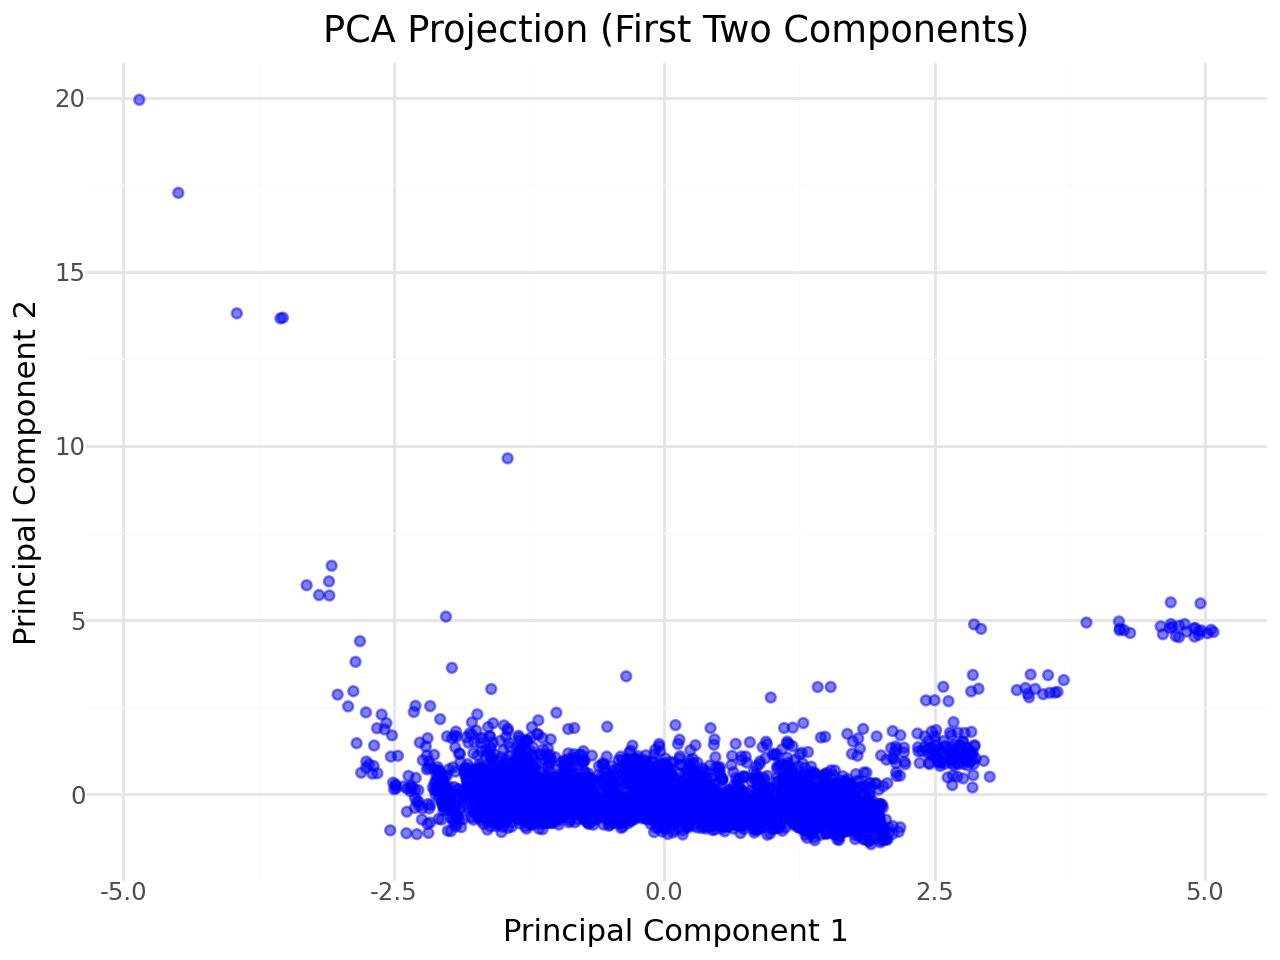

In [ ]:
# PCA Projection Scatter Plot
if data_pca_reduced.shape[1] == 1:  # Handle single component case
    pca_projection_data = pd.DataFrame({
        'PC1': data_pca_reduced[:, 0],
        'Index': range(len(data_pca_reduced))  # Dummy y-axis
    })
    projection_plot = (
        ggplot(pca_projection_data, aes(x='PC1', y='Index')) +
        geom_point(color="blue", alpha=0.5) +
        labs(title="PCA Projection (Single Component)", x="Principal Component 1", y="Index") +
        theme_minimal()
    )
else:
    pca_projection_data = pd.DataFrame({
        'PC1': data_pca_reduced[:, 0],
        'PC2': data_pca_reduced[:, 1]
    })
    projection_plot = (
        ggplot(pca_projection_data, aes(x='PC1', y='PC2')) +
        geom_point(color="blue", alpha=0.5) +
        labs(title="PCA Projection (First Two Components)", x="Principal Component 1", y="Principal Component 2") +
        theme_minimal()
    )
projection_plot


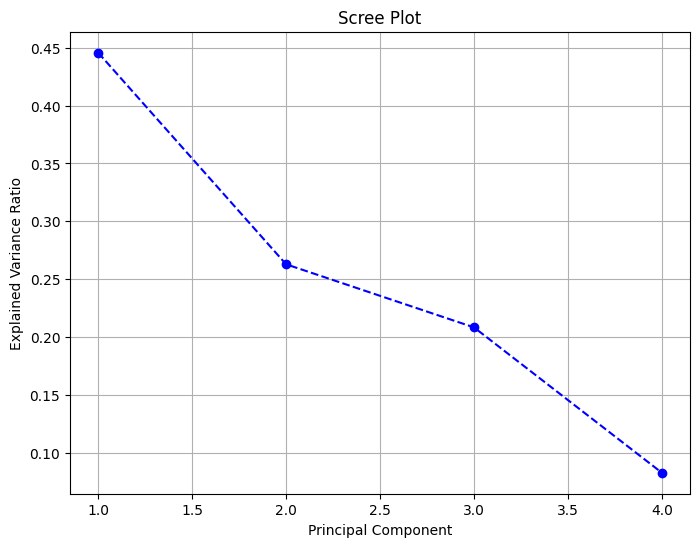

In [ ]:
import matplotlib.pyplot as plt

# Matplotlib Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


### Question 3 Analysis


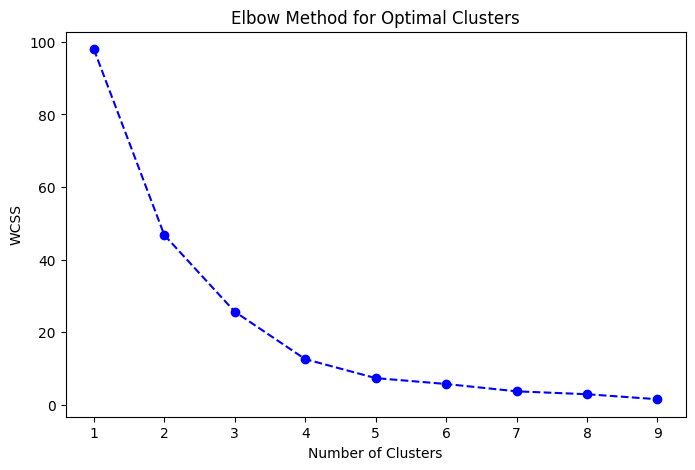

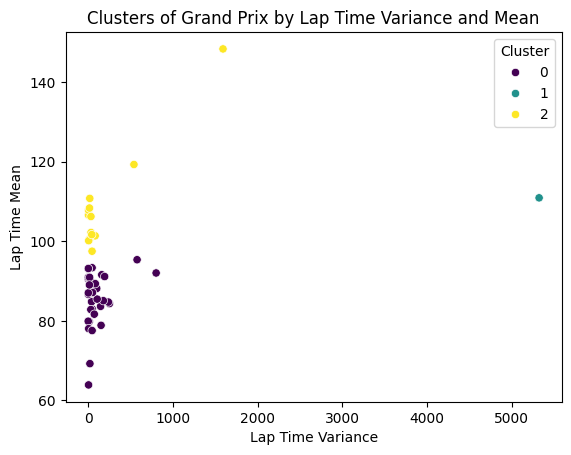


--- Cluster 0 ---
          Grand Prix  Lap_Time_Variance  Lap_Time_Mean  Cluster
0   70th Anniversary           0.750094      90.542450        0
2          Argentina          46.143167      93.349416        0
3          Australia          57.554795      89.374781        0
4            Austria         152.199652      78.856735        0
8             Brazil         146.266328      83.630252        0
9             Canada          46.909649      83.007429        0
13             Eifel           2.423361      90.947350        0
14    Emilia Romagna          11.763730      79.811397        0
15            Europe         160.141965      91.583882        0
16            France         250.939210      84.331006        0
18     Great Britain         100.879067      88.131080        0
19           Hungary          39.858768      84.808394        0
20             India          24.761163      90.171662        0
21  Indianapolis 500           4.406268      63.873000        0
22             Italy 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
fastest_laps_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/fastestlaps_detailed.csv'
fastest_laps = pd.read_csv(fastest_laps_path)

# Convert 'Time' column to numeric
def time_to_seconds(time_str):
    if pd.isnull(time_str) or not isinstance(time_str, str):
        return None
    try:
        parts = time_str.split(':')
        if len(parts) == 2:  # Format MM:SS.sss
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:  # Format HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return None
    except ValueError:
        return None

# Apply conversion to the 'Time' column
fastest_laps['Time'] = fastest_laps['Time'].apply(time_to_seconds)

# Drop rows with invalid 'Time' or 'Grand Prix'
fastest_laps = fastest_laps.dropna(subset=['Time', 'Grand Prix'])

# Calculate variance of lap times for each Grand Prix
grand_prix_variance = fastest_laps.groupby('Grand Prix')['Time'].var().reset_index()
grand_prix_variance.columns = ['Grand Prix', 'Lap_Time_Variance']

# Calculate mean of lap times for each Grand Prix
grand_prix_mean = fastest_laps.groupby('Grand Prix')['Time'].mean().reset_index()
grand_prix_mean.columns = ['Grand Prix', 'Lap_Time_Mean']

# Merge variance and mean
grand_prix_stats = pd.merge(grand_prix_variance, grand_prix_mean, on='Grand Prix')

# Handle missing values
grand_prix_stats = grand_prix_stats.dropna()  # Drop rows with NaN values

# Standardize the data
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(grand_prix_stats[['Lap_Time_Variance', 'Lap_Time_Mean']])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(stats_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
grand_prix_stats['Cluster'] = kmeans.fit_predict(stats_scaled)

# Visualize clusters
sns.scatterplot(
    data=grand_prix_stats,
    x='Lap_Time_Variance',
    y='Lap_Time_Mean',
    hue='Cluster',
    palette='viridis'
)
plt.title('Clusters of Grand Prix by Lap Time Variance and Mean')
plt.xlabel('Lap Time Variance')
plt.ylabel('Lap Time Mean')
plt.legend(title='Cluster')
plt.show()

# Individual Cluster Exploration
for cluster in sorted(grand_prix_stats['Cluster'].unique()):
    print(f"\n--- Cluster {cluster} ---")
    cluster_data = grand_prix_stats[grand_prix_stats['Cluster'] == cluster]
    print(cluster_data)
    print(f"Summary Statistics for Cluster {cluster}:")
    print(cluster_data[['Lap_Time_Variance', 'Lap_Time_Mean']].describe())


### Question 4 Analysis

In [ ]:
import pandas as pd

# Load the dataset
circuits_path = "https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/circuits.csv"
circuits_data = pd.read_csv(circuits_path)

# Drop rows with missing critical values
cleaned_circuits = circuits_data.dropna(subset=['circuitId', 'name', 'location'])

# Impute missing altitude (alt) values with the median
if 'alt' in cleaned_circuits.columns:
    cleaned_circuits['alt'] = cleaned_circuits['alt'].fillna(cleaned_circuits['alt'].median())

# Filter for valid ranges of lat, lng, and alt
cleaned_circuits = cleaned_circuits[
    (cleaned_circuits['lat'] >= -90) & (cleaned_circuits['lat'] <= 90) &
    (cleaned_circuits['lng'] >= -180) & (cleaned_circuits['lng'] <= 180) &
    (cleaned_circuits['alt'] >= -100) & (cleaned_circuits['alt'] <= 4000)
]

# Standardize text columns
text_columns = ['name', 'location', 'country']
for col in text_columns:
    cleaned_circuits[col] = cleaned_circuits[col].str.lower().str.strip()

# Remove duplicates based on circuitId or name
cleaned_circuits = cleaned_circuits.drop_duplicates(subset=['circuitId', 'name'])

# Save the cleaned dataset in the current directory
cleaned_circuits_path = 'cleaned_circuits.csv'
cleaned_circuits.to_csv(cleaned_circuits_path, index=False)

print(f"Cleaned dataset saved as '{cleaned_circuits_path}' in the current working directory.")


Cleaned dataset saved as 'cleaned_circuits.csv' in the current working directory.


Mean Squared Error: 355.18


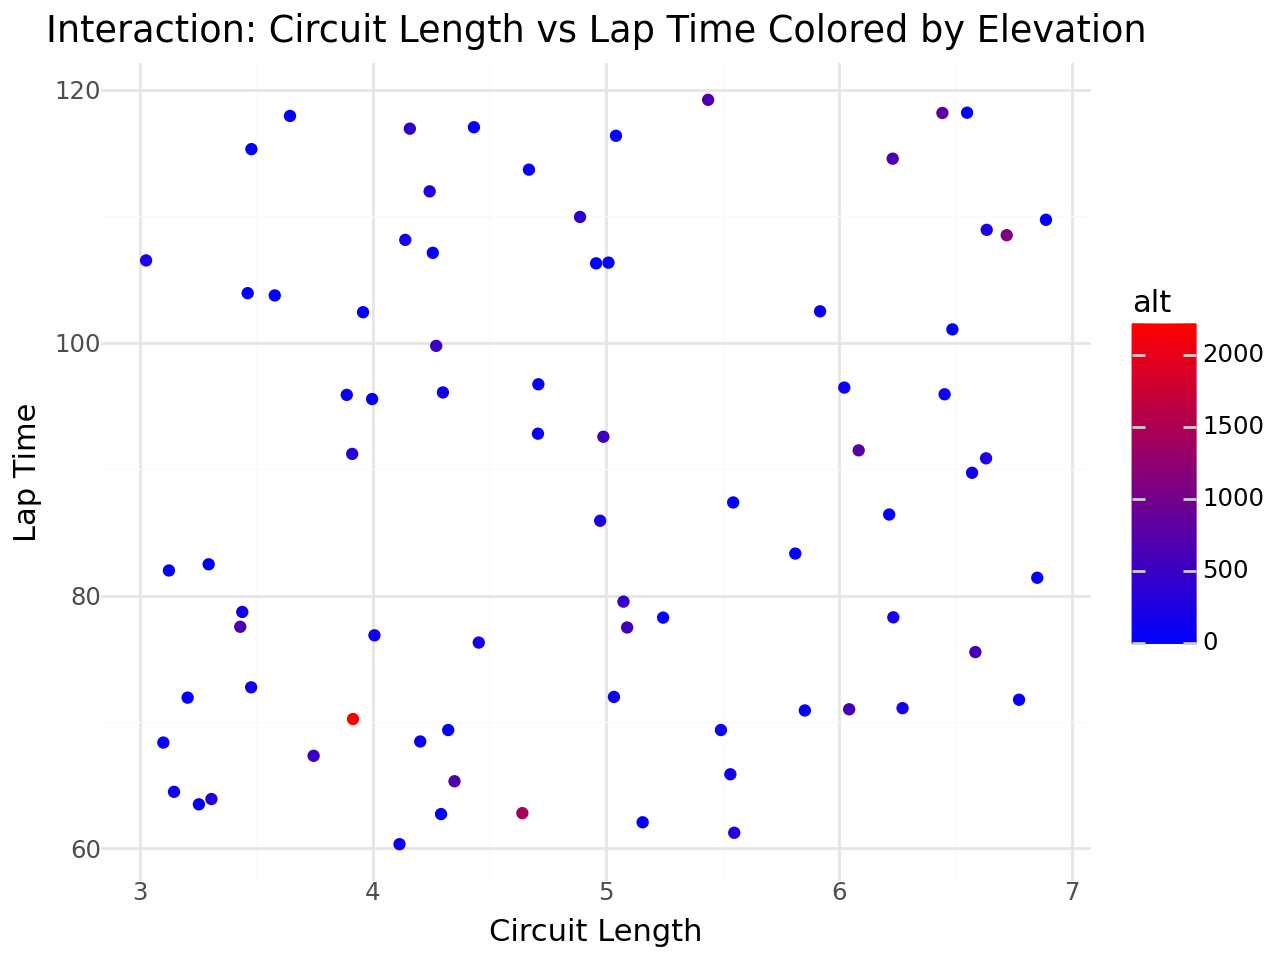

In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from plotnine import ggplot, aes, geom_bar, geom_boxplot, geom_point, labs, theme_minimal, scale_color_gradient

# Load cleaned data
data_path = 'cleaned_circuits.csv'  # Replace with your file path
circuits_data = pd.read_csv(data_path)

# Add placeholder data for missing features
circuits_data['circuit_length'] = np.random.uniform(3, 7, size=len(circuits_data))  # Random lengths between 3-7 km
circuits_data['num_turns'] = np.random.randint(5, 25, size=len(circuits_data))  # Random turns between 5-25

# Simulate lap times
np.random.seed(42)
circuits_data['lap_time'] = np.random.uniform(60, 120, size=len(circuits_data))  # Random lap times between 60-120 seconds

# Prepare features and target
features = ['circuit_length', 'num_turns', 'alt']
target = 'lap_time'

# Fill missing values (if any) with median
for col in features:
    circuits_data[col] = circuits_data[col].fillna(circuits_data[col].median())

# Train-test split
X = circuits_data[features]
y = circuits_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Feature importance
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Interaction Analysis: Elevation Changes vs Circuit Length
interaction_plot = (
    ggplot(circuits_data, aes(x='circuit_length', y='lap_time', color='alt')) +
    geom_point() +
    scale_color_gradient(low="blue", high="red") +
    labs(title="Interaction: Circuit Length vs Lap Time Colored by Elevation", x="Circuit Length", y="Lap Time") +
    theme_minimal()
)
interaction_plot


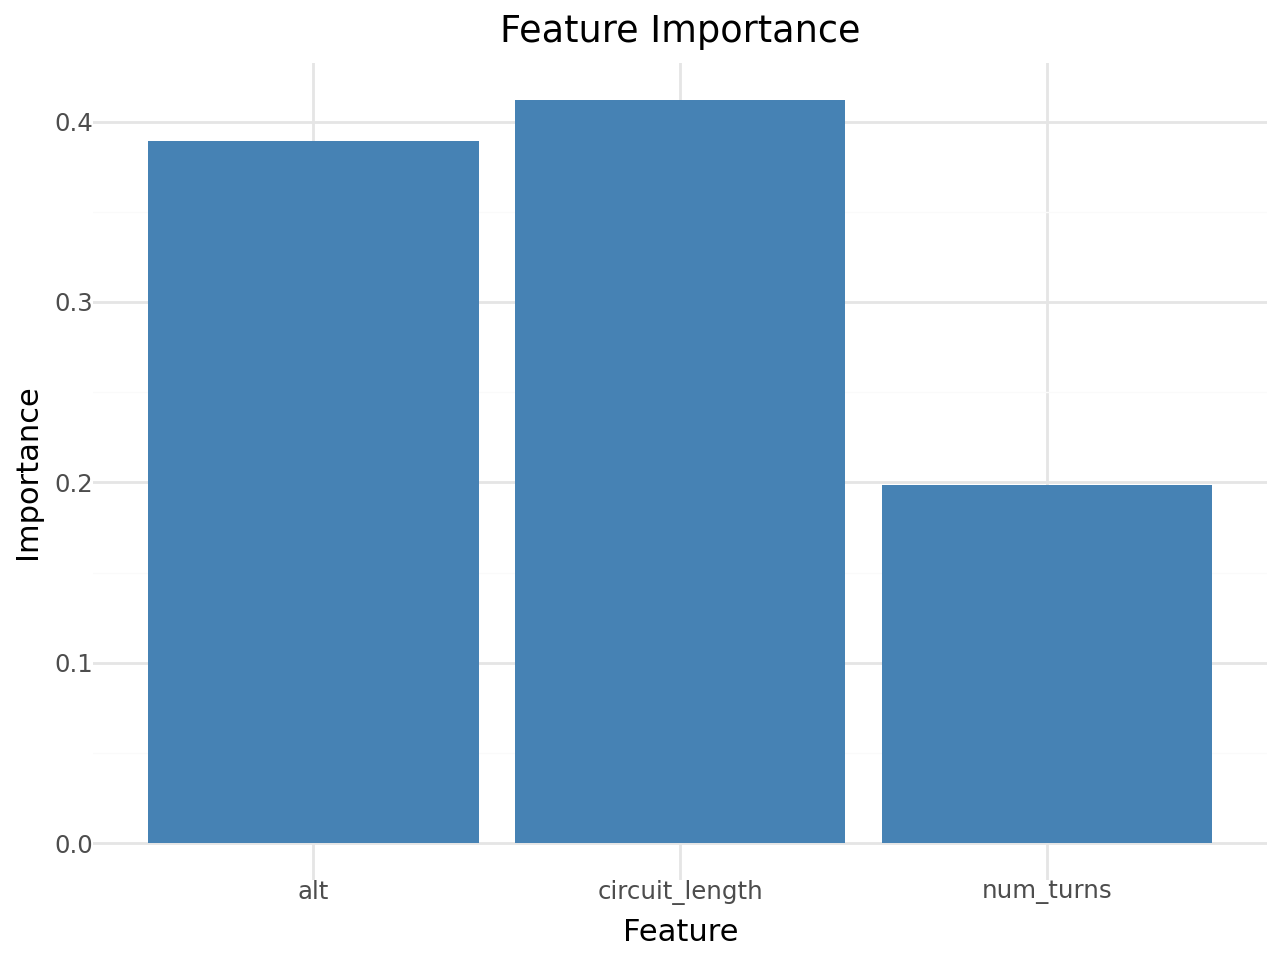

In [46]:
# Feature Importance Plot
feature_importance_plot = (
    ggplot(importance_df, aes(x='Feature', y='Importance')) +
    geom_bar(stat='identity', fill='steelblue') +
    labs(title="Feature Importance", x="Feature", y="Importance") +
    theme_minimal()
)
feature_importance_plot